In [1]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal


In [2]:
from environments import EnvironmentModel1 as Environment
from environments import translate_action_model1 as translate_action
from environments import reward_scaler_model1 as reward_scaler
from environments.model1 import scale_states

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np




class MemoryBuffer():
    
    def __init__(self, action_size, state_size, mem_size=5000, batch_size=1000):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.batch_size = batch_size
        self.action_size = action_size
        self.state_size =state_size
        
        
        self.state_memory = np.zeros((self.mem_size, state_size))
        self.q_memory = np.zeros((self.mem_size, action_size))
        
    def store_transition(self, state, q_values):
        index = self.mem_cntr % self.mem_size
        
        self.state_memory[index] = state
        self.q_memory[index] = q_values
        
        self.mem_cntr += 1
        
    def sample_batch(self):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size)

        states = self.state_memory[batch]
        q_values = self.q_memory[batch]
        return states, q_values

    
def build_network(input_dims, output_dims, fc1_size, fc2_size, lr):
    model = Sequential()
    model.add(Dense(fc1_size, activation='relu', input_dim=input_dims))
    model.add(Dense(fc2_size, activation='relu'))
    model.add(Dense(output_dims, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=lr))
    return model

class Agent():

    def __init__(self, alpha, gamma, layer1_size, layer2_size, statespace_dims, action_dims):
        self.lr = alpha
        self.gamma = gamma
        self.fc1_size = layer1_size
        self.fc2_size = layer2_size
        self.q_network = build_network(statespace_dims, action_dims, 
                                       layer1_size, layer2_size, alpha) 
        
        self.memory_buffer = MemoryBuffer(action_dims, statespace_dims)
    
    def learn(self, verbose=True):
        states, q_vals = self.memory_buffer.sample_batch()
        history_ = self.q_network.fit(states, q_vals, epochs=100, validation_split=0.6, 
                                    callbacks=[EarlyStopping()], verbose=0)
        
        
        n_epochs = history_.epoch[-1] 
        loss_, val_loss_ = history_.history['loss'][-1], history_.history['val_loss'][-1]
        
        if verbose:
            print(f'# epochs: {n_epochs}, loss: {loss_:.3}, val loss: {val_loss_:.3}')
            
    def remember(self, state, q_values):
        self.memory_buffer.store_transition(state, q_values)
        
    def act(self, state):
        state = state[np.newaxis, :]
        q_values = self.q_network.predict(state)
        action, q_value = np.argmax(q_values), q_values
        return action, q_value
        
    def predict_q_vals(self, new_states, rewards, done):
        rewards = rewards[np.newaxis, :]
        
        if done:
            q_vals = rewards
        else:
            q_vals_next = self.q_network.predict(new_states)
            q_vals_next_star = np.max(q_vals_next, axis=1)
            q_vals = rewards + self.gamma * q_vals_next_star

        return q_vals


In [93]:
class StateSpaceSampler():
    
    def __init__(self):
    
        self.Q_min = 60
        self.Q_max = 60
        
        self.K_min = 0
        self.K_max = 5
        
        self.G_min = 0.0
        self.G_max = 5.0
        
        self.Z_min = -200.0
        self.Z_max = 200.0
        
        self.beta_K_min = 1.0
        self.beta_K_max = 1.01
        
        self.beta_L_min = 1.0
        self.beta_L_max = 1.01
        
    def draw_state(self):
        Q = np.random.randint(self.Q_min, self.Q_max + 1)
        K = np.random.randint(self.K_min, self.K_max + 1)
        G = np.random.uniform(self.G_min, self.G_max)
        Z = np.random.uniform(self.Z_min, self.Z_max)
        
        beta_K = np.random.uniform(self.beta_K_min, self.beta_K_max)
        beta_L = np.random.uniform(self.beta_L_min, self.beta_L_max)
        
        return (Q, G, K, Z, beta_K, beta_L)
        
    def expand_pos_states(self):
        """creates to expand possible states"""
        self.Q_min = self.Q_min - 1


In [94]:
def transform_state(states):
    """helper for turning states in to parameters"""
    states_ = states[0:4]
    parameters = {
        'beta_K': states[4],
        'beta_L': states[5]
    }
    return states_, parameters

In [95]:
import pandas as pd
parameters = {
    'beta_K' : 1,
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11
}

In [100]:
env = Environment(**parameters)

In [101]:
agent = Agent(0.005, 0.99 ,64, 64, 6, 4)
sss = StateSpaceSampler()

In [102]:
ACTIONS = [0, 25, 37, 45]

rewards_all = list()
while sss.Q_min > 59:
    print(sss.Q_min)
    for i in range(1000):

        # ugly
        _states_ = sss.draw_state()
        _states, _params = transform_state(_states_)
        scaled_state = scale_states(*_states_)
        #print(scaled_state)


        # ugly
        rewards = np.zeros(shape=4)
        new_states = np.zeros(shape=(4, 6)) 
        for ix, action in enumerate(ACTIONS):
            env.reset(_states, _params)

            new_scaled_state, reward, done, _info = env.step(action)
            scaled_reward = reward_scaler(reward, env.beta_K, env.beta_L)
            rewards[ix] = scaled_reward
            new_states[ix] = new_scaled_state
        
        rewards_all.append(np.argmax(rewards))
        q_vals = agent.predict_q_vals(new_states, rewards, done)
        agent.remember(scaled_state, q_vals)

    agent.learn()
    sss.expand_pos_states()

60
# epochs: 5, loss: 0.000345, val loss: 0.000373


(array([ 18.,   0.,   0.,   0.,   0., 163.,   0.,   0.,   0., 819.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

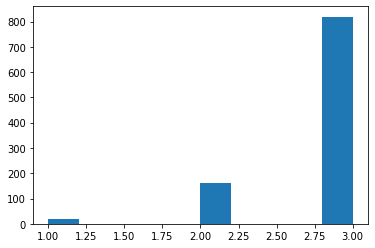

In [107]:
plt.hist(rewards_all)

In [109]:
parameters = {
    'beta_K' : 1,
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11
}
env = Environment(**parameters)

In [110]:
state = env.states
action, q_vals = agent.act(state)

In [111]:
q_vals

array([[-0.41339874, -0.49092442, -0.41697958, -0.2928377 ]],
      dtype=float32)

In [112]:
rewards_history, action_history = list(), list()
EPISODES = 50
agent.epsilon=0.0

for e in range(EPISODES):
    env.reset()
    state = env.states
    print(e)
    for time in range(18, 500):
        action, q_vals = agent.act(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [113]:
def random_action():
    act = np.random.randint(0, 4)
    return [0, 25, 37, 45][act]


In [114]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [115]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [116]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [117]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

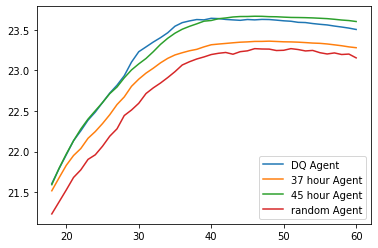

In [118]:
import matplotlib.pyplot as plt
#plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='Random Agent')
plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
plt.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent')
plt.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent')
plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent')


plt.legend()

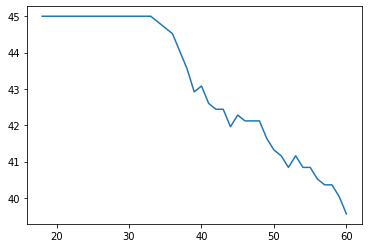

In [119]:
plt.plot(df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean())